# Traffic sign classification with Convolutional Neural Networks

In this notebook, you will face the real-world problem of automatically classify traffic signs. You will learn advanced techniques, such as image augmentation and learning rate scheduling, and it will be a good benchmark to assess your understanding of Convolutional Neural Networks.

# 1. Setting up the environment
For simplicity, we will import almost all packages you need in this first codeblock. Notice that we define a `data_format` string which holds the data format (or image ordering) used by Keras. We will use it to load the appropriate pre-defined dataset.

In [1]:
import numpy as np

from sklearn.model_selection import train_test_split

import h5py

from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras import backend as K
K.set_image_data_format('channels_first')

from matplotlib import pyplot as plt
%matplotlib inline

NUM_CLASSES = 43
IMG_SIZE = 48

if K.image_data_format() == 'channels_first':
    data_format = 'NCWH'
else:
    data_format = 'NWHC'

Using TensorFlow backend.


# 2. The data: GTSRB dataset

From [GTSRB's website](benchmark.ini.rub.de/?section=gtsrb):
>_The German Traffic Sign Benchmark is a multi-class, single-image classification challenge held at the International Joint Conference on Neural Networks (IJCNN) 2011. We cordially invite researchers from relevant fields to participate: The competition is designed to allow for participation without special domain knowledge. Our benchmark has the following properties:_
- _Single-image, multi-class classification problem_
- _More than 40 classes_
- _More than 50,000 images in total_
- _Large, lifelike database_

We will use a pre-processed version of the dataset, which we stored on scratch for NCHW format. The data is stored as an HDF5 file, thus we will use `h5py` to load it. We then also split the data in train and validation sets, using 20% of the original dataset for validation.

In [2]:
train_filename = 'scratch/data/X_'+data_format+'.h5'

with  h5py.File(train_filename) as hf: 
    X, Y = hf['imgs'][:], hf['labels'][:]
print("Loaded images from {}".format(train_filename))

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

Loaded images from scratch/data/X_NCWH.h5


We also have a separate file for the test dataset, which we load.

In [3]:
test_filename = 'scratch/data/X_'+data_format+'_test.h5'

with  h5py.File(test_filename) as hf: 
    X_test, Y_test = hf['imgs'][:], hf['labels'][:]
print("Loaded images from {}".format(test_filename))

Loaded images from scratch/data/X_NCWH_test.h5


Explore the dataset, extract some stats, like number of images and check that `X_train`, `X_val`, `X_test` and their labels are as you expect them!

In [5]:
n_train_samples = X_train.shape[0]
input_shape       = X_train.shape[1:]
output_dim      = Y_train.shape[1]

print("{} train samples".format(n_train_samples))
print("Input dimension: {} ".format(input_dim))
print("Output dimension: {}".format(output_dim))

31367 train samples
Input dimension: (3, 48, 48) 
Output dimension: 43


# 3. Preprocessing the data

Nothing to do here! The data has already been prepared for us. If you are interested, here is the function which was used to prepare the data:

In [6]:
def preprocess_img(img):
    # Histogram normalization in y
    hsv = color.rgb2hsv(img)
    hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
    img = color.hsv2rgb(hsv)

    # central crop
    min_side = min(img.shape[:-1])
    centre = img.shape[0]//2, img.shape[1]//2
    img = img[centre[0]-min_side//2:centre[0]+min_side//2,
              centre[1]-min_side//2:centre[1]+min_side//2,
              :]

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    # roll color axis to axis 0
    if data_format == 'NCWH':
        img = np.rollaxis(img,-1)

    return img

# 4. Visualizing the data

Go ahead and explore the dataset a little further! Use `plt.imshow` to show some samples, but be careful, because the function expects images in `NWHC` format, thus you will probably have to use `np.transpose` ([here](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.transpose.html)...)

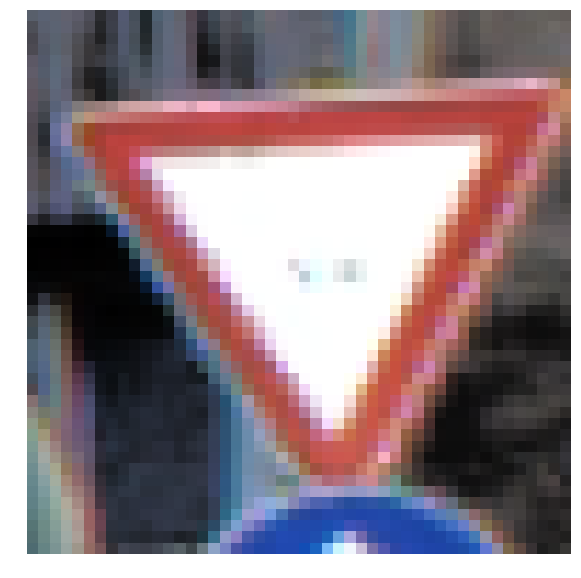

In [7]:
plt.figure(figsize=(10,10))

#TODO use plt.imshow to display one or more samples from the datasets!
img_index = 120;
if data_format == 'NWHC':
    plt.imshow(X_test[img_index]);
else:
    plt.imshow(np.transpose(X_test[img_index], (1, 2, 0)));
plt.axis('off');

# 5. Applying Neural Networks to the problem

We need to classify images, thus we most likely want to start from Convolutional Neural Networks! This time, a starting CNN is given for you, just be careful, it expects the variable `input_shape` to hold the shape of the input images (you should have defined this above), and you have to assign the right value to `output_dim`, which will be the dimension of the NN output. Now take time to analyze the CNN and write down the output dimensions and the number of parameters of each layer (take a piece of paper, or open a separate text file in this lab). Once you are done, add the classic call to `model.summary()` and see if it matches your expectations! 

As you see, we created a function which returns the CNN. This will be helpful later, when we will change training strategy and add data augmentation, without touching the NN topology!

In [44]:
def cnn_model():
    model = Sequential()
    
    output_dim = NUM_CLASSES
        
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=input_shape,
                     activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_dim, activation='softmax'))
    return model

model = cnn_model()

#TODO: call summary() only after you've written down parameter count and output shape for each layer!
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 32, 48, 48)        896       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 46, 46)        9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 23, 23)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 32, 23, 23)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 64, 23, 23)        18496     
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 64, 21, 21)        36928     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 64, 10, 10)        0         
__________

Time to compile the network! We start with a simple SGD optimizer, which we initialized with non-default parameters. 

In [45]:
# let's train the model using SGD + Nesterov momentum
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])

Still one thing to do before training the network! We define a `lr_schedule` callback, which will return a learning rate `lr` based on the epoch, and will be called by Keras, at training time, at the beginning of each epoch. As it is defined now, it would just return a constant learning rate, but it would not lead to good accuracy. Modify the function so that it multiplies the initial learning rate by a factor of $0.1^{\lfloor epochs/10 \rfloor}$, where $\lfloor \cdot \rfloor$ is the floor operator, i.e. rounding towards the smallest integer.

In [46]:
batch_size = 32
epochs = 20

def lr_schedule(epoch):
    #TODO return a reduce the learning rate by a factor of 10 each 10 epochs
    return lr*(0.1**(epoch//10))

All callbacks are passed to the `fit` function through an array, which must contain callback objects. In our case, we create an object of type `LearningRateScheduler` which takes as argument the function we just defined. That's all!

Let's start the training!

In [47]:
history_callback=model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_val, Y_val),
          callbacks=[LearningRateScheduler(lr_schedule)])

Train on 31367 samples, validate on 7842 samples
Epoch 1/20
31367/31367 [==============================] - 8s 247us/step - loss: 1.7850 - acc: 0.5005 - val_loss: 0.2285 - val_acc: 0.9318
Epoch 2/20
31367/31367 [==============================] - 7s 227us/step - loss: 0.2918 - acc: 0.9121 - val_loss: 0.0954 - val_acc: 0.9714
Epoch 3/20
31367/31367 [==============================] - 7s 228us/step - loss: 0.1641 - acc: 0.9502 - val_loss: 0.0569 - val_acc: 0.9832
Epoch 4/20
31367/31367 [==============================] - 7s 227us/step - loss: 0.1102 - acc: 0.9649 - val_loss: 0.0528 - val_acc: 0.9847
Epoch 5/20
31367/31367 [==============================] - 7s 229us/step - loss: 0.0857 - acc: 0.9730 - val_loss: 0.0367 - val_acc: 0.9895
Epoch 6/20
31367/31367 [==============================] - 7s 228us/step - loss: 0.0704 - acc: 0.9772 - val_loss: 0.0309 - val_acc: 0.9917
Epoch 7/20
31367/31367 [==============================] - 7s 227us/step - loss: 0.0576 - acc: 0.9832 - val_loss: 0.0359 - v

Ok, very high numbers, aren't they? What about the test accuracy? Go ahead and check it!

In [48]:
#TODO use model.evaluate with the test dataset to obtain test accuracy
score = model.evaluate(X_test, Y_test, verbose=0)

print("Test accuracy = {}".format(score[1]))

Test accuracy = 0.9735550277589902


This accuracy should be lower than the train and validation ones. OK, can we do better? Well, the data set is small, even if wer keep training, we will not have enough samples to acheve better generalization, thus, we look at something different: data augmentation!

# 6. Data augmentation in Keras

In Keras, we cak use `ImageDataGenerator`, which takes an array of images and applies random transformations to them. We can define some parameters for such transformations. [Look at the documentation](https://keras.io/preprocessing/image/), and understand what type of modifications we are introducing in the code block below, and why we need to call `datagen.fit`!

In [49]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=False, 
                            featurewise_std_normalization=False, 
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.,)

datagen.fit(X_train)

`ImageDataGenerator` does not only modify the images. It also acts as a generator, which yields batches of samples which can be consumed by the training functions. In the code block below, we use the function `flow` to get the first batch (properly transposed, so that we can easily display it below).

In [50]:
if data_format == 'NCWH':
    X_aug = np.transpose(datagen.flow(X_train, batch_size=32, shuffle=False)[0][0:5], (0, 2, 3, 1))
else:
    X_aug = datagen.flow(X_train, batch_size=32, shuffle=False)[0][0:5]

Currently, `X_aug` holds the augmented versions of the first `5` train images. Plot the images and their augmented counterparts side to side and see what types of transformations have been applied.

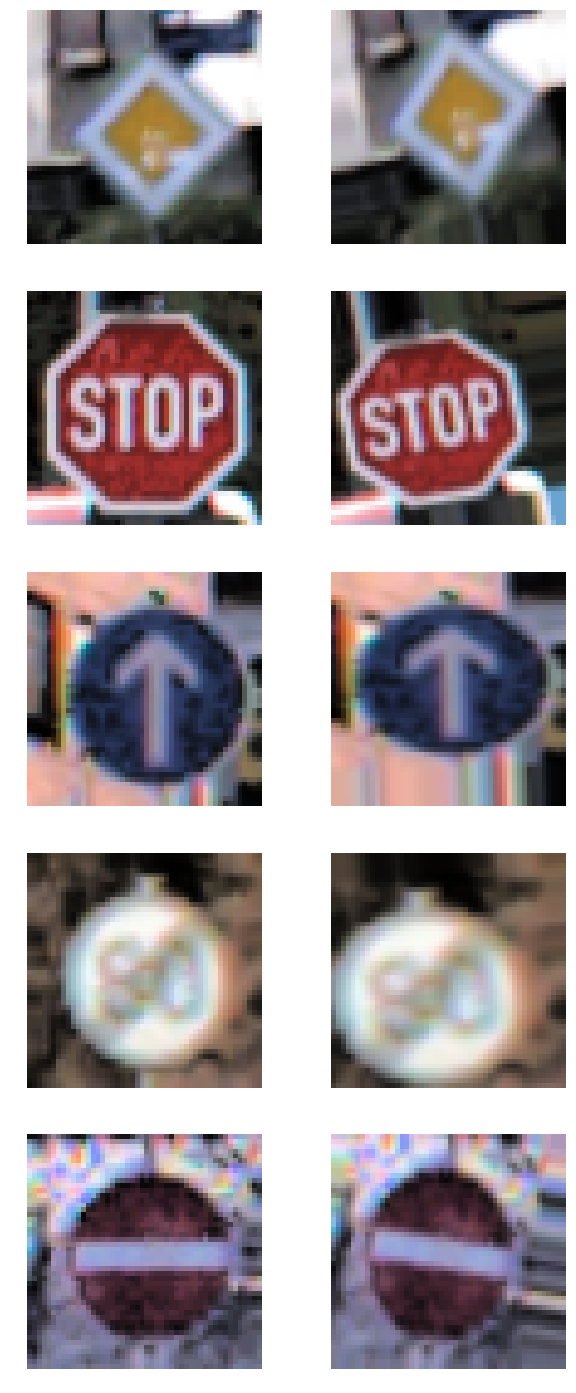

In [51]:
plt.figure(figsize=(10,25))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    # TODO use imshow to display the i-th original image (in NWHC format!)
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)));
    plt.axis('off')
    plt.subplot(5,2,2*i+2)
    # TODO use imshow to display the augmented image
    plt.imshow(X_aug[i]);
    plt.axis('off')

Now go up by two code blocks, run the augmentation again and plot the resulting images. What happened? 

Well, the augmented images should be different from the previous ones, that's because the generator has applied a new set of random transformations to them. At training time, at every epoch, images will be slightly different, and this will help the network to focus on relevant features (and generalize much better). Let's do the training again and see what happens! First we re-initialize the model weights, by re-instantiating and compiling the model.

In [52]:
# Re-initialize models 

model = cnn_model()

model.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])

Next, we start the training. Instead of the function `fit`, which would feed the network samples taken from the original image tensors, we use `fit_generator`, which takes a generator as argument. Obviously, we will use our image augmenting generator. Let's see what happens.

In [53]:
aug_history_callback = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                            epochs=epochs,
                            validation_data=(X_val, Y_val),
                            callbacks=[LearningRateScheduler(lr_schedule)])

Epoch 1/20
981/981 [==============================] - 22s 22ms/step - loss: 2.5749 - acc: 0.2675 - val_loss: 0.9070 - val_acc: 0.7002
Epoch 2/20
981/981 [==============================] - 21s 22ms/step - loss: 0.8858 - acc: 0.7148 - val_loss: 0.1892 - val_acc: 0.9491
Epoch 3/20
981/981 [==============================] - 21s 22ms/step - loss: 0.3940 - acc: 0.8762 - val_loss: 0.0740 - val_acc: 0.9767
Epoch 4/20
981/981 [==============================] - 21s 22ms/step - loss: 0.2585 - acc: 0.9200 - val_loss: 0.0523 - val_acc: 0.9837
Epoch 5/20
981/981 [==============================] - 21s 22ms/step - loss: 0.1926 - acc: 0.9404 - val_loss: 0.0337 - val_acc: 0.9898
Epoch 6/20
981/981 [==============================] - 21s 22ms/step - loss: 0.1523 - acc: 0.9539 - val_loss: 0.0197 - val_acc: 0.9938
Epoch 7/20
981/981 [==============================] - 22s 22ms/step - loss: 0.1350 - acc: 0.9586 - val_loss: 0.0419 - val_acc: 0.9865
Epoch 8/20
981/981 [==============================] - 22s 22ms

In [54]:
score = model.evaluate(X_test, Y_test, verbose=0)

print("Test accuracy = {}".format(score[1]))

Test accuracy = 0.986460807648143


You should now have reached a higher test accuracy, congratulations! Plot convergence data from `history_callback` and `aug_history_callback` and see how the two training curves differ... can you understand why?

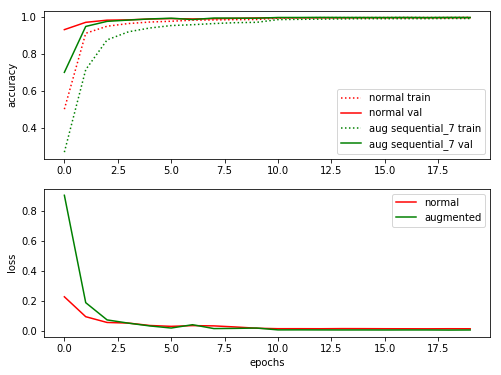

In [58]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))

colorstring = "rgbcmk"

train_acc = history_callback.history['acc']
train_loss = history_callback.history['loss']
val_acc = history_callback.history['val_acc']
val_loss = history_callback.history['val_loss']
aug_train_acc = aug_history_callback.history['acc']
aug_train_loss = aug_history_callback.history['loss']
aug_val_acc = aug_history_callback.history['val_acc']
aug_val_loss = aug_history_callback.history['val_loss']
ax1.plot(train_acc, colorstring[0]+':', label="normal train")
ax1.plot(val_acc, colorstring[0], label="normal val")
ax2.plot(val_loss, colorstring[0], label="normal")
ax1.plot(aug_train_acc, colorstring[1]+':', label="aug "+model.name+" train")
ax1.plot(aug_val_acc, colorstring[1], label="aug " + model.name+" val")
ax2.plot(aug_val_loss, colorstring[1], label="augmented")

ax1.set_ylabel('accuracy')
ax2.set_ylabel('loss')
ax2.set_xlabel('epochs')
ax1.legend()
ax2.legend()
plt.show()